<a href="https://colab.research.google.com/github/claudio-bon/pos-tagging-rnn/blob/main/pos_tagging_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.

**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).

**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

# Initial Setup
In this section it will be imported the packages used in this notebook.

In [ ]:
# system packages
import os
import shutil
import sys
import time
import random

# data and numerical management packages
import pandas as pd
import numpy as np

# useful during debugging (progress bars)
from tqdm import tqdm, notebook

from IPython.display import display
import matplotlib.pyplot as plt

import math

import torch
import torchtext

random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
np.random.seed(random_seed)

if torch.cuda.is_available():
    print('Used device: GPU')
    device = torch.device("cuda")
else:
    print('Used device: CPU')
    device = torch.device("cpu")

Used device: GPU


# Dataset loading
In this section are going to be performed all the preparation steps that will allow to use the dataset for the purposes of the assignment.<br>
In particular, once the dataset has been downloaded, it's going to be loaded in a DataFrame having for each row a column containing a list of tokens and another containing the list of tags associated to such tokens.<br>
Then a "split" column will be added to the DataFrame stating the membership of each row either to the training, validation or test set.

### Download

In [ ]:
from urllib import request
import zipfile

# Config
print('Current work directory: {}'.format(os.getcwd()))

dataset_folder = os.path.join(os.getcwd(), 'Datasets')

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, 'Assignment3_dataset.zip')

print(dataset_path)

def download_dataset(download_path, url):
    if not os.path.exists(download_path):
        print('Downloading dataset...')
        request.urlretrieve(url, download_path)
        print('Download complete!')

def extract_dataset(download_path, extract_path):
    print('Extracting dataset... (it may take a while...)')
    with zipfile.ZipFile(download_path, 'r') as loaded_zip:
        loaded_zip.extractall(extract_path)
    print('Extraction completed!')

# Download
download_dataset(dataset_path, url)

# Extraction
extract_dataset(dataset_path, dataset_folder)

Current work directory: /content
/content/Datasets/Assignment3_dataset.zip
Extracting dataset... (it may take a while...)
Extraction completed!


### Create Pandas' DataFrame

In [ ]:
# Config
dataset_name = 'dependency_treebank'
debug = False

def encode_dataset(dataset_name, debug=True):
    dataframe_rows = []

    folder = os.path.join(os.getcwd(), 'Datasets', dataset_name)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path):
                # open the file
                with open(file_path, mode='r', encoding='utf-8') as text_file:
                    # read it and extract informations
                    tokens = []
                    tags = []
                    for line in text_file:
                        try:
                            token, tag, _ = line.split()    # ignore the numeric values
                            tokens.append(token)
                            tags.append(tag)
                            
                        except ValueError:
                            if len(line.split())>0:
                                raise ValueError


                    # create single dataframe row
                    dataframe_row = {
                        'tokens': tokens,
                        'tags': tags,
                    }

                                # print detailed info for the first file
                    if debug:
                        print(file_path)
                        print(filename)
                        print(tokens)
                        print(tags)
                        debug = False
                    dataframe_rows.append(dataframe_row)

        except Exception as e:
            print('Failed to process %s. Reason: %s' % (file_path, e))
            sys.exit(0)

    folder = os.path.join(os.getcwd(), 'Datasets', 'Dataframes', dataset_name)
    if not os.path.exists(folder):
        os.makedirs(folder)

    # transform the list of rows in a proper dataframe
    df = pd.DataFrame(dataframe_rows)
    df = df[['tokens', 'tags']]
    dataframe_path = os.path.join(folder, dataset_name + '.pkl')
    df.to_pickle(dataframe_path)

    return df


# Encoding
print('Encoding dataset...')
df = encode_dataset(dataset_name, debug)
print('Encoding completed!')

Encoding dataset...
Encoding completed!


Splitting the DataFrame in training, validation and test set.

In [ ]:
from sklearn.model_selection import train_test_split

def split_df(df, split, random_state=42):
    """
    Given a DataFrame and a list/tuple containing a valid split this function
    will perform on df as many splits as the length of the parameter split.
    The size of each split will be as specified in the split parameter.

    Parameters
    ----------
        df : pandas.DataFrame
            DataFrame to be splitted.
        split : tuple or list
            List or tuple of n elements that defines n splits of the DataFrame df.
        random_state : int, 42 by default
            Parameter used to make the split more deterministic.
    Returns
    -------
        df_splits : list
            List containing at each position i the elements of the ith split.
    """
    if isinstance(split,tuple):
        split = list(split)

    if not isinstance(split,list):
        raise ValueError('Split should be either a tuple or a list')

    n_splits = len(split)

    if n_splits<=1:
        raise ValueError('The minimum number of splits is 2, currently requested {}'.format(n_splits))

    if split[-1]==-1:
        split.pop(-1)

    if not isinstance(split[0], (int,float)):
        raise ValueError('The elements of split should be either int or float')
    
    for s in split:
        if not isinstance(s,type(split[0])):
            raise ValueError('All elements of split should be of the same type')

    for s in split:
        if s <= 0:
            raise ValueError('All elements of split (except the last one) should be strictly positive')


    df_size = df.shape[0]
    
    if isinstance(split[0], float):
        split_type='Float'
        max_value = 1.0
    elif isinstance(split[0], int):
        split_type='Int'
        max_value = df_size
        
    if len(split)==n_splits and sum(split)!=df_size:
        raise ValueError('{} value sum should be equal to {}, it is {} instead'.format(split_type,max_value,sum(split)))
    if len(split)==n_splits-1 and sum(split)>df_size:
        raise ValueError('{} value sum should be less then or equal to {}, it is {} instead'.format(split_type,max_value,sum(split)))

    if isinstance(split[0], float):
        split = [int(math.floor(df_size*s)) for s in split]

    split.append(df_size-sum(split))



    df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    df_splits = []
    current_split = 0
    for i in range(n_splits):
        df_splits.append(df.loc[current_split:current_split+split[i]-1, :])
        current_split += split[i]


    return df_splits


def split_train_val_test(df, split, method=None, random_state=42):
    """
    Given a DataFrame and a valid split this function will return the DataFrame
    with an additional column "split" containing informations pertaining the membership
    of each row either to the training, validation or test set.

    Parameters
    ----------
        df : pandas.DataFrame
            DataFrame to be splitted.
        split : tuple or list
            A tuple or a list composed of 3 elements indicating how to perform
            the split. If the last element is -1 the test column will be filled
            automatically with the remaining df's rows.
        method : None or 'sklearn', None by default
            if 'sklearn' is passed the split will be performed relying on scikit-learn's
            train_test_split function. Else, if None is passed, an handcrafted solution will
            be used.
        random_state : int, 42 by default
            Parameter used to make the split more deterministic.
    Returns
    -------
        splitted_df : pandas.DataFrame
            DataFrame df with additional "split" column.
    """
    if len(split)!=3:
        raise ValueError()

    if 'split' in df.columns:
        df.drop(columns='split', inplace=True)

    if method is None:
        training, validation, test = split_df(df, split, random_state)
    elif method == 'sklearn':
        training, validation = train_test_split(df, train_size=split[0], random_state=random_state)
        validation, test = train_test_split(validation, train_size=split[1], random_state=random_state)

    training.insert(training.shape[1],'split',['train' for _ in range(training.shape[0])])
    validation.insert(validation.shape[1],'split',['val' for _ in range(validation.shape[0])])
    test.insert(test.shape[1],'split',['test' for _ in range(test.shape[0])])

    return pd.concat([training, validation, test])

In [ ]:
df = split_train_val_test(df, (100,50,-1))
display(df.head())

,tokens,tags,split
0,"[James, L., Pate, ,, 54-year-old, executive, v...","[NNP, NNP, NNP, ,, JJ, NN, NN, NN, ,, VBD, VBN...",train
1,"[The, Life, Insurance, Co., of, Georgia, has, ...","[DT, NNP, NNP, NNP, IN, NNP, VBZ, RB, VBN, DT,...",train
2,"[John, R., Stevens, ,, 49, years, old, ,, was,...","[NNP, NNP, NNP, ,, CD, NNS, JJ, ,, VBD, VBN, J...",train
3,"[The, parent, of, Younkers, ,, after, failing,...","[DT, NN, IN, NNP, ,, IN, VBG, TO, VB, DT, NN, ...",train
4,"[Your, Oct., 6, article, ``, Japan, 's, Financ...","[PRP$, NNP, CD, NN, ``, NNP, POS, JJ, NNS, VBP...",train


### Data visualization

Dataset size: (199, 3)

Dataset columns: ['tokens' 'tags' 'split']

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tokens  199 non-null    object
 1   tags    199 non-null    object
 2   split   199 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
None 

Dataset Head:


,tokens,tags,split
0,"[James, L., Pate, ,, 54-year-old, executive, v...","[NNP, NNP, NNP, ,, JJ, NN, NN, NN, ,, VBD, VBN...",train
1,"[The, Life, Insurance, Co., of, Georgia, has, ...","[DT, NNP, NNP, NNP, IN, NNP, VBZ, RB, VBN, DT,...",train
2,"[John, R., Stevens, ,, 49, years, old, ,, was,...","[NNP, NNP, NNP, ,, CD, NNS, JJ, ,, VBD, VBN, J...",train
3,"[The, parent, of, Younkers, ,, after, failing,...","[DT, NN, IN, NNP, ,, IN, VBG, TO, VB, DT, NN, ...",train
4,"[Your, Oct., 6, article, ``, Japan, 's, Financ...","[PRP$, NNP, CD, NN, ``, NNP, POS, JJ, NNS, VBP...",train



Dataset Description:


,tokens,tags,split
count,199,199,199
unique,199,199,3
top,"[World, sugar, futures, prices, soared, on, ru...","[NN, NN, NNS, NNS, VBD, IN, NNS, IN, NNP, ,, D...",train
freq,1,1,100



Split value counts:
train    100
val       50
test      49
Name: split, dtype: int64


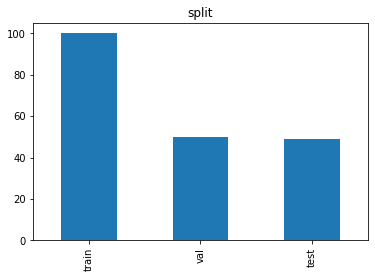


Distribution of tags in the splits:


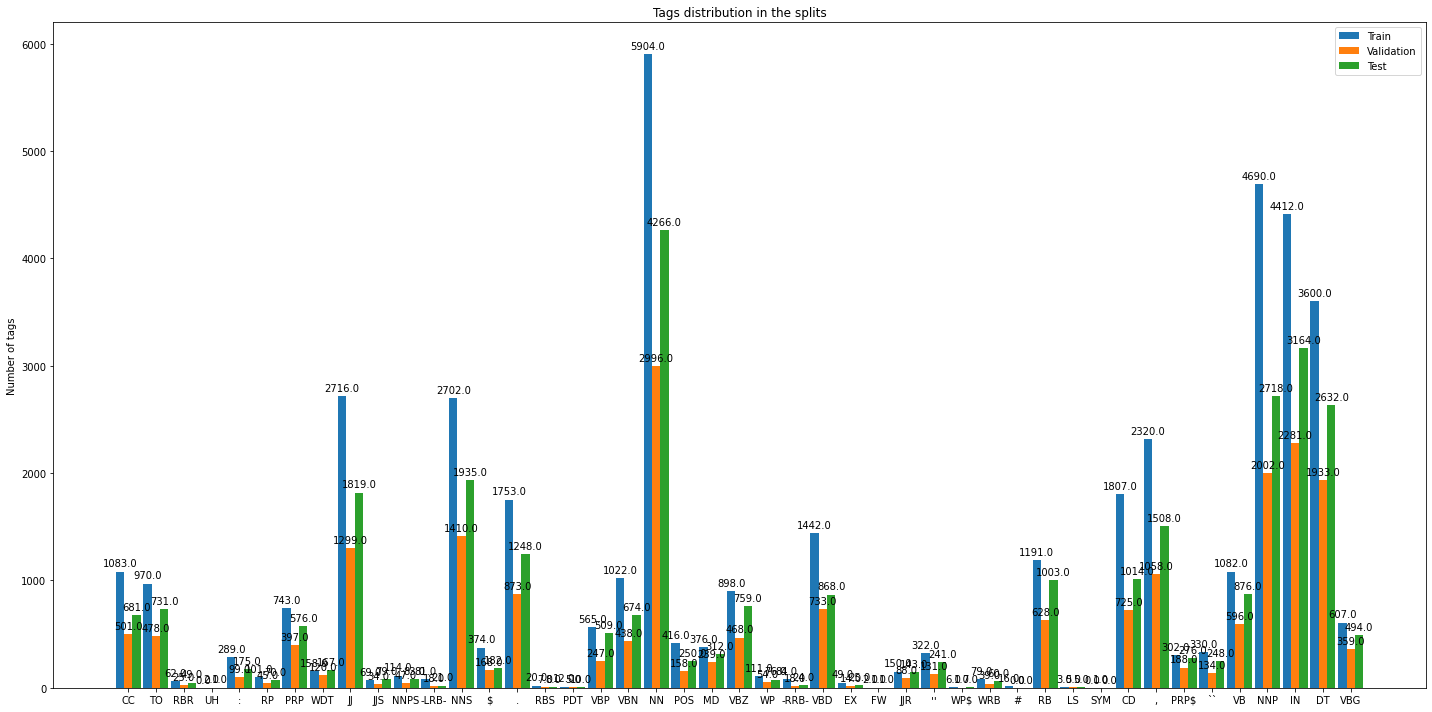

In [ ]:
print('Dataset size: {}\n'.format(df.shape))

print('Dataset columns: {}\n'.format(df.columns.values))

print('Dataset Info:')
print(df.info(),'\n')

print('Dataset Head:')
display(df.head())

print('\nDataset Description:')
display(df.describe())

print('\nSplit value counts:')
print(df['split'].value_counts())
df['split'].value_counts().plot(kind='bar', title='split')
plt.show()


print('\nDistribution of tags in the splits:')
tags_labels_idx = {tag:idx for idx,tag in enumerate(set([elem for seq in df['tags'] for elem in seq]))}
tags_bars_train = np.zeros(len(tags_labels_idx))
tags_bars_val = np.zeros(len(tags_labels_idx))
tags_bars_test = np.zeros(len(tags_labels_idx))
for idx, row in df.loc[df['split'] == 'train'].iterrows():
    for tag in row['tags']:
        tags_bars_train[tags_labels_idx[tag]] += 1
for idx, row in df.loc[df['split'] == 'val'].iterrows():
    for tag in row['tags']:
        tags_bars_val[tags_labels_idx[tag]] += 1
for idx, row in df.loc[df['split'] == 'test'].iterrows():
    for tag in row['tags']:
        tags_bars_test[tags_labels_idx[tag]] += 1

tags_labels = list(tags_labels_idx.keys())

x = np.arange(len(tags_labels))  # the label locations
width = 0.30  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))
train_rects = ax.bar(x - width, tags_bars_train, width, label='Train')
valid_rects = ax.bar(x, tags_bars_val, width, label='Validation')
test_rects = ax.bar(x + width, tags_bars_test, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of tags')
ax.set_title('Tags distribution in the splits')
ax.set_xticks(x)
ax.set_xticklabels(tags_labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(train_rects)
autolabel(valid_rects)
autolabel(test_rects)

fig.tight_layout()

plt.show()

# Dataset Encoding
Next is the encoding of the tags and the tokens

In [ ]:
def create_vocabulary(df, column):
    """
    Build a vocabulary from a given DataFrame's column.

    Parameters
    ----------
        df : pandas.DataFrame
            The DataFrame on which the vocabulary will be computed.
        column : str
            The column of the dataframe on which the vocabulary will be computed.

    Returns
    -------
        vocabulary : set
            Vocabulary built from the given DataFrame's column.
    """
    return set([elem for seq in df[column] for elem in seq])

## Encode Tags
The tags will be encoded by means of a simple enumeration.<br>
The tags corresponding to punctuation symbols will be encoded in the same way as their stand-in symbol (called IGNORE_ENC) which will be ignored during the computation of the loss, accuracy and F1-macro.

In [ ]:
PUNCTUATION_TAGS = ['.','#','\'\'',',',':','``','$']
#IGNORE_ENC will be mainly used as stand in for punctuation and then left out
#from the computation of loss function, accuracy and F1-macro
IGNORE_ENC = '<IGN>'

#Create the vocabulary of the tags without the punctuation symbols and include the "ignore element"
vocabulary_tags = create_vocabulary(df, 'tags')
vocabulary_tags = {tag for tag in vocabulary_tags if tag not in PUNCTUATION_TAGS} | {IGNORE_ENC}


#Enumerate the tags
encoding_to_tag = dict(enumerate(vocabulary_tags))

tag_to_encoding = {t:e for e,t in encoding_to_tag.items()}
#Giving the punctuations the same encoding as their stand-in symbol (PUNCTUATION_ENC)
punctuation_to_encoding = {pct:tag_to_encoding[IGNORE_ENC] for pct in PUNCTUATION_TAGS}
tag_to_encoding = {**tag_to_encoding, **punctuation_to_encoding}


print(f'Number of tags: {len(vocabulary_tags)-1+len(PUNCTUATION_TAGS)}\n')
print('tag_to_encoding:')
print(tag_to_encoding)
print('\nencoding_to_tag:')
print(encoding_to_tag)

Number of tags: 45

tag_to_encoding:
{'CC': 0, 'RBR': 1, 'TO': 2, 'UH': 3, 'RP': 4, 'PRP': 5, 'WDT': 6, 'JJ': 7, 'JJS': 8, 'NNPS': 9, '-LRB-': 10, 'NNS': 11, 'PDT': 12, 'RBS': 13, 'VBP': 14, 'VBN': 15, 'NN': 16, 'POS': 17, 'MD': 18, '<IGN>': 19, 'VBZ': 20, 'WP': 21, '-RRB-': 22, 'VBD': 23, 'EX': 24, 'FW': 25, 'JJR': 26, 'WP$': 27, 'WRB': 28, 'RB': 29, 'LS': 30, 'SYM': 31, 'CD': 32, 'PRP$': 33, 'VB': 34, 'NNP': 35, 'IN': 36, 'DT': 37, 'VBG': 38, '.': 19, '#': 19, "''": 19, ',': 19, ':': 19, '``': 19, '$': 19}

encoding_to_tag:
{0: 'CC', 1: 'RBR', 2: 'TO', 3: 'UH', 4: 'RP', 5: 'PRP', 6: 'WDT', 7: 'JJ', 8: 'JJS', 9: 'NNPS', 10: '-LRB-', 11: 'NNS', 12: 'PDT', 13: 'RBS', 14: 'VBP', 15: 'VBN', 16: 'NN', 17: 'POS', 18: 'MD', 19: '<IGN>', 20: 'VBZ', 21: 'WP', 22: '-RRB-', 23: 'VBD', 24: 'EX', 25: 'FW', 26: 'JJR', 27: 'WP$', 28: 'WRB', 29: 'RB', 30: 'LS', 31: 'SYM', 32: 'CD', 33: 'PRP$', 34: 'VB', 35: 'NNP', 36: 'IN', 37: 'DT', 38: 'VBG'}


## Words Embedding
In order to encode the tokens it has been decided to use a more sophisticated technique with respect to one hot encoding. Therefore the tokens will be encoded using GloVe embeddings.

### Download GloVe
In this section it will be downloaded GloVe.<br>
To change the dimensions of the embeddings downloaded it is sufficient to change the variable `embedding_dim`; as of now it has been setted to 300 since it has been observed that doing so improves the overall outcome of the task assigned.<br>
Since downloading GloVe's embeddings is a time consuming operation, the dowloaded embeddings will be saved in a file so that, in case this cell should be executed again, the download will not restart but it will instead load the embeddings from the file.

In [ ]:
import gensim
import gensim.downloader as gloader
from pathlib import Path

def load_embedding_model(embedding_dim):
    """
    Loads a pre-trained word embedding model via gensim library.

    Parameters
    ----------
        embedding_dim : int
            Size of the embedding space to consider.

    Returns
    -------
        emb_model : gensim.models.keyedvectors.KeyedVectors
            Pre-trained word embedding model.
    """

    download_path = "glove-wiki-gigaword-{}".format(embedding_dim)

    #Check download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model


#Supported GloVe embedding dimensions -> 50, 100, 200, 300
embedding_dim = 300

embedding_folder = os.path.join(os.getcwd(), 'Embeddings')
Path(embedding_folder).mkdir(parents=True, exist_ok=True)

embedding_path = os.path.join(embedding_folder,'glove-wiki-gigaword-{}'.format(embedding_dim))

#When the embedding model is downloaded save it to memory so that if the cell is
#re-executed it's not needed to download it again
if not os.path.exists(embedding_path):
    print('Downloading glove-wiki-gigaword-{} ...'.format(embedding_dim))
    embedding_model = load_embedding_model(embedding_dim)
    print('Saving the model to memory ...')
    os.mknod(os.path.join(embedding_folder,'glove-wiki-gigaword-{}.vectors.npy'.format(embedding_dim)))
    embedding_model.save(embedding_path)
else:
    print('The requested GloVe embedding model has already been downloaded')
    print('Loading glove-wiki-gigaword-{} ...'.format(embedding_dim))
    embedding_model = gensim.models.KeyedVectors.load(embedding_path)

The requested GloVe embedding model has already been downloaded
Loading glove-wiki-gigaword-300 ...


### Retrieve the embeddings
Here will be retrieved the embeddings from the embedding model for the training set, validation set and test set separately.<br>
The embeddings built for each set is in the form of a vocabulary and contains the embeddings of the tokens present in the given set which can be found either in the embedding model or, as in case of tokens not present in the embedding model (OOV token), they can be computed.<br>
In particular, in order to compute the embeddings for the OOV tokens, it has been followed the two following approaches:
- In the first case (and the most simple), the embeddings are generated randomically by sampling from a normal distribution, but in case the token considered is a composition of two or more words (there are many of those in the documents) look for the embeddings of such words in the embedding model, if all of them are present use the mean of their embeddings as the embedding of the composite word, else generate it randomically (always from a normal distribution).
- In the second case a co-occurence matrix for each set is generated and the embeddings of each OOV token are a weighted average of its neghbours.

The OOV tokens and their relative embeddings that have been retrieved for each set, have been used for the construction of the following sets as to avoid that OOV tokens present in different sets gets associated with different embedding.

In [ ]:
def composite_and_in_vocab(token, embedding_model):
    """
    Check whether token is composite (in the sense that it is formed from different
    tokens separated by "-" characters) and if its components are present in the
    embedding_model.

    Parameters
    ----------
        token : str
            Token on which will be performed the composicity check.
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            The embedding model on which the sub-tokens of the token will be
            checked to belong to.

    Returns
    -------
        checked : bool
            True if token is composite and its components belong to
            embedding_model, False otherwise.
    """
    if '-' in token:
        for t in token.split('-'):
            if t.lower() not in embedding_model:
                return False
        return True

    return False

def get_composite_embeddings(token, embedding_model):
    """
    Retrieve all the token's sub-tokens' embeddings (separated from "-" characters)
    from the embedding model and compute their mean.

    Parameters
    ----------
        token : str
            Composite token.
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            The embedding model that will be used to retrieve the token's
            sub-tokens' embeddings.
    
    Returns
    -------
        embeds_composite : numpy.ndarray
            Mean of the the token's sub-tokens' embeddings.
    """
    splitted_token = token.split('-')
    embeds_composite = np.ndarray((len(splitted_token), embedding_model.vector_size))
    for idx,t in enumerate(splitted_token):
        embeds_composite[idx,:] = embedding_model[t.lower()]
    return embeds_composite.mean(axis=0)


def create_co_occurrence_matrix(df, window_size=1):
    """
    Build the co-occurrence matrix

    Parameters
    ----------
        df : pandas.DataFrame
            The DataFrame containing the documents on which the co-occurrence
            matrix will be built.
        window_size : int, 1 by default
            The size of the context window used to create the co-occurence matrix.
            Should be left to 1.

    Returns
    -------
        co_occurrence_matrix : pandas.DataFrame
            The co-occurrence matrix built from df.
    """
    vocabulary = create_vocabulary(df, 'tokens')
    co_occurrence_matrix = pd.DataFrame(data=0, columns=vocabulary, index=vocabulary)

    for tokens in notebook.tqdm(df['tokens'], position=0, leave=True):
        for idx,token in enumerate(tokens):
            start = idx-window_size if idx-window_size>=0 else 0
            end = idx+window_size+1 if idx+window_size+1<=len(tokens) else len(tokens)
            context_window = tokens[start:end]
            co_occurrence_matrix.loc[token,context_window] += 1

    return co_occurrence_matrix


def weighted_mean_neighbor_embeddings(token, embedding_model, co_occurrence_matrix):
    """
    Compute the weighted average between the neighbouring tokens of a given token

    Parameters
    ----------
        token : str
            Token which neighbours' embeddings weighted average has to be
            computed.
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            Embedding model used to retrieve the embeddings of token's
            neighbouring tokens.
        co_occurrence_matrix : pandas.DataFrame
            Co-occurence matrix.
    
    Returns
    -------
        average : numpy.ndarray
            The weghted average (based on co_occurence_matrix) of token's
            neighbouring tokens' embeddings.
    """
    token_neighbours = co_occurrence_matrix.loc[token, co_occurrence_matrix.loc[token]>0]
    embeds = np.array([embedding_model[name.lower()] for name,occ in token_neighbours.iteritems() if name.lower() in embedding_model])
    occurrences = np.array([occ for name,occ in token_neighbours.iteritems() if name.lower() in embedding_model])
    try:
        return np.average(embeds, axis=0, weights=occurrences)
    except:
        return np.random.normal(size=embedding_model.vector_size)


def get_embeddings(df, embedding_model, additional_dict={}, co_occurrence_matrix=None):
    """
    Retrieve for each token present in df its embedding taking it either from
    the embedding model, from the additional_dict or, in case there are tokens
    not present in the previous two vocabularies, generating it either randomically
    (with the exception of composite tokens which subtokens are to be found in the
    embedding model) or computing the weighted average of the token's neighbourhood
    defined by the co-occurence matrix.

    Parameters
    ----------
        df : pandas.DataFrame
            DataFrame which will be used to create the vocabulary. Each token
            of the vocabulary will be then associated with an embedding.
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            Dictionary-like structure that contains words embedding.
        additional_dict : dict, {} by default
            Contains ulterior embeddings.
        co_occurrence_matrix : pandas.DataFrame, None by default
            Co-occurence matrix used to compute OOV words.
            If it is None then the embeddings are sampled from a normal
            distribution with the exception composite tokens (tokens that
            contains other tokens separated by the "-" character) which, if
            its sub-tokens are in the embedding model, get computed by taking
            the mean of the sub-tokens' embeddings.

    Returns
    -------
        embeddings : dict
            The embeddings of the tokens presents in the vocabulary generated
            by df.
        embeddings_oov : dict
            The embeddings of the tokens not presents either in embedding_model
            nor in additional_dict
    """

    vocabulary = create_vocabulary(df, 'tokens')

    #Out of vocabulary tokens
    OOV_tokens = [token for token in vocabulary if token.lower() not in embedding_model and token not in additional_dict]

    #Recomputed vocabulary without OOV tokens
    vocabulary_no_oov = [token for token in vocabulary if token not in OOV_tokens and token not in additional_dict]

    #Takes the embeddings of the tokens that are not OOV from the embedding model
    embeddings = {token:embedding_model[token.lower()] for token in vocabulary_no_oov}

    if co_occurrence_matrix is None:
        #Build OOV embeddings without the co-occurrence matrix
        embeddings_oov = {token:np.random.normal(size=embedding_model.vector_size) if not composite_and_in_vocab(token, embedding_model) \
                          else get_composite_embeddings(token, embedding_model) \
                          for token in OOV_tokens}
    else:
        #Build OOV embeddings with the co-occurrence matrix
        embeddings_oov = {token:weighted_mean_neighbor_embeddings(token, embedding_model, co_occurrence_matrix) \
                          for token in OOV_tokens}

    embeddings = {**embeddings, **embeddings_oov, **additional_dict}

    return embeddings, embeddings_oov




#Creation of the co-occurence matrices
if 'co_occurrence_matrix_train' not in globals():
    print('Creating co-occurence matrix train ...')
    co_occurrence_matrix_train = create_co_occurrence_matrix(df.loc[df['split'] == 'train'])
    print('Done\n')

if 'co_occurrence_matrix_val' not in globals():
    print('Creating co-occurence matrix validation ...')
    co_occurrence_matrix_val = create_co_occurrence_matrix(df.loc[df['split'] == 'val'])
    print('Done\n')
    
if 'co_occurrence_matrix_test' not in globals():
    print('Creating co-occurence matrix test ...')
    co_occurrence_matrix_test = create_co_occurrence_matrix(df.loc[df['split'] == 'test'])
    print('Done\n')


print('Creating embeddings ...')
ign_embedding_dict = {IGNORE_ENC : np.zeros(embedding_dim)}

#Creation of the training set's embeddings
embeddings_train, embeddings_oov_train = get_embeddings(df = df.loc[df['split'] == 'train'],
                                                        embedding_model = embedding_model,
                                                        additional_dict = ign_embedding_dict,
                                                        co_occurrence_matrix = co_occurrence_matrix_train)

#Creation of the validation set's embeddings
embeddings_val, embeddings_oov_val = get_embeddings(df = df.loc[df['split'] == 'val'],
                                                    embedding_model = embedding_model,
                                                    additional_dict = {**embeddings_oov_train, **ign_embedding_dict},
                                                    co_occurrence_matrix = co_occurrence_matrix_val)

#Creation of the test set's embeddings
embeddings_test, embeddings_oov_test = get_embeddings(df = df.loc[df['split'] == 'test'],
                                                      embedding_model = embedding_model,
                                                      additional_dict = {**embeddings_oov_train,**embeddings_oov_val, **ign_embedding_dict},
                                                      co_occurrence_matrix = co_occurrence_matrix_test)
print('Done')

Creating embeddings ...
Done


# Iterators preparation
For semplicity in handling the data a dataset and an iterator have been implemented.<br>
The aim of the dataset is to encode the tokens and the tags and to store them in tensor properly loaded in a given device. It has also been implemented `__getitem__` and `__len__` functions which allows it to be iterated on with more ease.<br>
The iterator iterate (through the implementation of the methods ` __iter__` and `__next__`) on a given dataset returning each cycle a couple tokens-tags as a dictionary.<br>
As a design decision it has been decided that what it's going to be stored in the dataset it's not the raw data itself but its encoding, this would allow to save computational time during the training phase given by the online encoding of the tokens/tags. Doing so would also allow to drop the Embedding layer that, otherwise, would have needed to be defined inside the model.

In [ ]:
class SimpleDataset(torch.utils.data.Dataset):
    """
    Handles the data.
    It has two main tasks: encode the data and load it on tensors and, if it is
    required, transfer it to the device memory.

    Attributes
    ----------
        data : list of dict
            Contains the (encoded) data of the dataset. Each element of the list is a
            dictionary that contains as many elements as the number of columns
            of the preprocessed DataFrame (by means of the initialization parameters
            selected_columns and excluded_columns) passed to the initialization function.
            Each element of the dictionary contains a tensor allocated on the
            given device.
        encoders : dict of dict
            Each element of the dictionary contains an encoder (which is itself
            a dictionary) for a column of the dataset.
        device : torch.device
            Device to transfer the tensors to (the ones present in the attribute
            data)

    Methods
    -------
        shuffle():
            Shuffle the data present in the attribute data.
    """
    def __init__(self, df, encoders, selected_columns=None, excluded_columns=None, device=torch.device('cpu')):
        """
        Makes use of the DataFrame to build the data.
        In particular the DataFrame gets preprocessed by means of selected_columns
        and excluded_columns and then each row of the remaining DataFrame gets
        inserted in the data by transforming each of its row in a dictionary
        containing at each key the DataFrame's column's content casted to a tensor
        which is then moved of the specified device.

        Parameters
        ----------
            df : DataFrame
                DataFrame over which the dataset will be built.
            encoders : dict of dict
                It'a dictionary that have as keys the columns of the DataFrame
                and hold the encoders for each column.
            selected_columns : list of str or str, None by default
                Columns of the DataFrame that will be used.
            excluded_columns : list of str or str, None by default
                Columns of the DataFrame that will be discarded. If selected_columns
                is specified then this parameter is ignored.
            device : torch.device, torch.device('cpu') by default
                Device where the dataset will be placed to.
        """
        self.encoders = encoders
        self.device = device

        if selected_columns is not None:
            df = df[selected_columns]
        elif excluded_columns is not None:
            df = df.drop(columns=excluded_columns)

        #Encode the data and store it on the given device
        self.data = [{col : torch.tensor([self.encoders[col][elem] for elem in row[col]], device=self.device, requires_grad=False) \
                      for col in df.columns} \
                     for idx, row in df.iterrows()]

    def shuffle(self):
        """
        Shuffle data.
        """
        random.shuffle(self.data)
    def __len__(self):
        """
        Returns the length of data.
        """
        return len(self.data)
    def __getitem__(self, idx):
        """
        Get the item at the given index

        Parameters
        ----------
            idx : int
                Index of the object contained in data that has to be returned
        Returns
        -------
            element : dict
                The element of data at idx
        """
        return self.data[idx]


class SimpleIterator():
    """
    Implements __iter__ and __next__ allowing to loop over a given dataset.

    Attributes
    ----------
        dataset : SimpleDataset
            Dataset to iterate over.
        shuffle : bool
            Wheter to shuffle the dataset or not.
    """
    def __init__(self, dataset, shuffle=False):
        """
        Initialization function.

        Parameters
        ----------
            dataset : SimpleDataset
                Dataset which will be used to iterate.
            shuffle : bool, False by default
                Wheter to shuffle the dataset or not.
        """
        self.dataset = dataset
        self.shuffle = shuffle

        if self.shuffle:
            self.dataset.shuffle()
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.dataset)
    def __iter__(self):
        """
        Initialize the looping phase
        """
        self.idx = 0
        return self
    def __next__(self):
        """
        Takes the next element from the dataset
        """
        if self.idx < len(self.dataset):
            current_idx = self.idx
            self.idx += 1
            return self.dataset[current_idx]
        else:
            raise StopIteration

In [ ]:
print('Preparing training set ...')
training_df = SimpleDataset(df.loc[df['split'] == 'train'],
                            excluded_columns='split',
                            encoders={'tokens':embeddings_train, 'tags':tag_to_encoding},
                            device=device)
print('Done\n')
print('Preparing validation set ...')
validation_df = SimpleDataset(df.loc[df['split'] == 'val'],
                              excluded_columns='split',
                              encoders={'tokens':embeddings_val, 'tags':tag_to_encoding},
                              device=device)
print('Done\n')
print('Preparing test set ...')
test_df = SimpleDataset(df.loc[df['split'] == 'test'],
                        excluded_columns='split',
                        encoders={'tokens':embeddings_test, 'tags':tag_to_encoding},
                        device=device)
print('Done')


training_iterator = SimpleIterator(dataset=training_df,
                                   shuffle=True)
validation_iterator = SimpleIterator(dataset=validation_df,
                                     shuffle=True)
test_iterator = SimpleIterator(dataset=test_df,
                               shuffle=True)

Preparing training set ...
Done

Preparing validation set ...
Done

Preparing test set ...
Done


# Training functionalities

### Training class
For ease of use purposes the training loop has been implemented as a class.
The `__call__` method implements the actual training loop while the method `train` implements the both the training phase and the validation phase. This differentiation occurs through the setting of a flag: calling directly `train` would begin the training phase while calling it though `evaluate` would start the evaluation procedure.<br>
During the excecution of the training loop at each epoch the accuracy and loss are collected and used by the function display_results for visualization purposes.<br>
The training loop has been wrapped in a try-except block. This would allow to catch the `KeyboardInterrupt` exception so that the execution can be stopped at any time without causing any particular issues. In case the execution is stopped before its natural ending it will be loaded the model corresponding to the best accuracy found so far.

In [ ]:
class Train():
    """
    Implementation of the training loop

    Attributes
    ----------
        model : torch.nn.Module
        num_epochs : int
        criterion : torch.nn.Module
            Loss function.
        optimizer : torch.optim.Optimizer
        lr_scheduler : torch.optim.lr_scheduler._LRScheduler or object, None by default
        lt_scheduler_metric : bool, False by default
            If true then the validation loss is passed to the lr_scheduler as metric.
        ignore_enc : int, None by default
            The encoding of the token that has to be ignored.
        init_model : bool, True by default
            If True the model gets initialized before the execution of the training loop.
        state_path : str, 'Assignment3-model.pt' by default
            The path where to save the model's state.
        return_best_model : bool, True by default
            If true before the ending of the training loop function gets loaded
            in memory the model with the best configuration found so far.

    Methods
    -------
        accuracy_score(preds, y):
            Computes the accuracy of a prediction.
        epoch_time(start_time, end_time):
            Prints the elapsed time between the start of the epoch and its end.
        train(iterator, is_train=True):
            Training function.
        evaluate(iterator):
            Evaluation function.
        save_state():
            Save the state of the training.
        load_state(load_model_only=False):
            Load the last saved state of the training.
        __call__(train_iterator, valid_iterator, verbose=True):
            Implementation of the training loop.
    """
    def __init__(self, model, num_epochs, criterion, optimizer, lr_scheduler=None, lr_scheduler_metric=False,
                 ignore_enc=None, init_model=True, state_path='Assignment3-model.pt', return_best_model=True):
        self.model = model
        self.num_epochs = num_epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.lr_scheduler_metric = lr_scheduler_metric
        self.ignore_enc = ignore_enc
        self.init_model = init_model
        self.state_path = state_path
        self.return_best_model = return_best_model


    def accuracy_score(self, preds, y):
        """
        Returns the accuracy score.

        Parameters
        ----------
            preds : torch.tensor
                Prediction made by the model.
            y : torch.tensor
                Ground truth.
        Returns
        -------
            accuracy : torch.tensor
                Accuracy score.
        """
        if preds.shape[1] > 1:
            max_preds = preds.argmax(dim = 1, keepdim = True).view(-1) # get the index of the max probability
        else:
            max_preds = preds.view(-1)

        # Indexes of the elements to be considered for the computation of the accuracy
        non_ignored_elements = (y != self.ignore_enc)
        correct = max_preds[non_ignored_elements].eq(y[non_ignored_elements])

        return correct.sum() / torch.tensor([y[non_ignored_elements].shape[0]],
                                                dtype=torch.float,
                                                device=device)

    def epoch_time(self, start_time, end_time):
        """
        Compute the elapsed time between two given measurements.

        Parameters
        ----------
            start_time
                Beginning of the measurament.
            end_time
                Ending of the measurament.
        Returns
        -------
            elapsed_mins :
                Elapsed minutes.
            elapsed_secs :
                Elapsed seconds.

        """
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs


    def train(self, iterator, is_train=True):
        """
        Training function which has been adapted to be used also for
        validation.

        Parameters
        ----------
            iterator: SimpleIterator
                Dataset on which perform the training / validation.
            is_train : bool, True by default

        Returns
        -------
            Loss and accuracy.
        """
        epoch_loss = 0
        epoch_acc = 0
        
        if is_train:
            self.model.train()
        else:
            self.model.eval()

        with torch.set_grad_enabled(is_train):
            for batch in iterator:
                text = batch['tokens']
                tags = batch['tags']
                
                if is_train:
                    self.optimizer.zero_grad()
                
                predictions = self.model(text)
                
                predictions = predictions.view(-1, predictions.shape[-1])
                tags = tags.view(-1)
                
                loss = self.criterion(predictions, tags)
                
                acc = self.accuracy_score(predictions, tags)
                
                if is_train:
                    loss.backward()
                    self.optimizer.step()
                
                epoch_loss += loss.item()
                epoch_acc += acc.item()
            
        return epoch_loss / len(iterator), epoch_acc / len(iterator)


    def evaluate(self, iterator):
        """
        Compute the loss and accuracy over the validation set.

        Parameters
        ----------
            iterator : SimpleIterator
                Dataset on which perform the validation.
        Returns
        -------
            Loss and accuracy.
        """
        return self.train(iterator, is_train=False)

    def save_state(self):
        """
        Save the current state of the training procedure.
        """
        torch.save({'model_state_dict':self.model.state_dict(),
                    'optimizer_state_dict':self.optimizer.state_dict(),
                    'lr_scheduler_state_dict':self.lr_scheduler.state_dict() if self.lr_scheduler is not None else None,
                    'best_epoch':self.best_epoch,
                    'best_valid_acc':self.best_valid_acc,
                    }, self.state_path)
        
    def load_state(self, load_model_only=False):
        """
        Load the last saved training's state.

        Parameters
        ----------
            load_model_only : bool, False by default
                If True it will be loaded only the model, the best_epoch and
                the best valid_accuracy (The latter 2 only for visualization purposes).
        """
        checkpoint = torch.load(self.state_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.best_epoch = checkpoint['best_epoch']
        self.best_valid_acc = checkpoint['best_valid_acc']

        if load_model_only:
            return

        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.lr_scheduler is not None:
            self.lr_scheduler.load_state_dict(checkpoint['lr_scheduler_state_dict'])

        self.train_loss_history = self.train_loss_history[:self.best_epoch+1]
        self.valid_loss_history = self.valid_loss_history[:self.best_epoch+1]
        self.train_acc_history = self.train_acc_history[:self.best_epoch+1]
        self.valid_acc_history = self.valid_acc_history[:self.best_epoch+1]


    def __call__(self, train_iterator, valid_iterator, verbose=True):
        """
        Implementation of the training loop.

        Parameters
        ----------
            train_iterator : SimpleIterator
                Iterator containing the training data.
            valid_iterator : SimpleItarator
                Iterator containing the validation data.
            verbose : bool, True by default
                If True the function prints the results obtained out of each epoch.
        """
        if self.init_model:
            if verbose:
                print('Parameters Initialization ...')
            self.model.init_params()
            if verbose:
                print('Done\n')

        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator

        if verbose:
            print('Best validation accuracy initialization ...')
        self.best_valid_acc = self.evaluate(valid_iterator)[1]
        if verbose:
            print('Done\n')
        self.best_epoch = -1
        self.train_acc_history, self.valid_acc_history, self.train_loss_history, self.valid_loss_history = [],[],[],[]

        #Save the initial state
        self.save_state()

        try:
            if verbose:
                print('Beginning training procedure\n')
            for epoch in range(self.num_epochs):

                start_time = time.time()
                
                train_loss, train_acc = self.train(train_iterator)
                valid_loss, valid_acc = self.evaluate(valid_iterator)
                
                end_time = time.time()

                epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)
                
                if verbose:
                    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
                    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
                    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

                if valid_acc > self.best_valid_acc:
                    self.best_valid_acc = valid_acc
                    self.best_epoch = epoch
                    #Save the training state corresponding to the best prediction
                    #found so far
                    self.save_state()

                #Update the learining rate
                if self.lr_scheduler is not None:
                    if verbose:
                        current_lr = self.optimizer.param_groups[0]['lr']
                    if not self.lr_scheduler_metric:
                        self.lr_scheduler.step()
                    else:
                        self.lr_scheduler.step(valid_loss)
                    if verbose:
                        next_lr = self.optimizer.param_groups[0]['lr']
                        print(f"\tlr: {current_lr} --> {next_lr}")

                self.train_loss_history.append(train_loss)
                self.valid_loss_history.append(valid_loss)
                self.train_acc_history.append(train_acc)
                self.valid_acc_history.append(valid_acc)

        #In case the execution gets interrupted before its natural ending the last
        #saved training's state will be loaded into memory
        except KeyboardInterrupt:
            print('\n\nExecution Interrupted')
            print('Resuming from the previous best epoch ...')
            self.load_state()
            print('Loaded model at epoch {}, and with validation accuracy of {}%'.format(self.best_epoch+1,self.best_valid_acc*100))

        else:
            #If self.return_best_model is True then at the end of the execution of the training loop
            #it will be loaded on the model the best found one during the training procedure.
            if self.return_best_model:
                print('\n\nLoading the model with the best validation accuracy ...')
                self.load_state(load_model_only=True)
                print('Model loaded with results of epoch {} and with validation accuracy of {}%'.format(self.best_epoch+1,self.best_valid_acc*100))

        #Remove the folder where the training state is located
        os.remove(self.state_path)


    def display_results(self):
        """
        Plot the history of the accuracy and of the loss.
        """
        print('\nBest validation accuracy found at epoch {}: {:.4f}%'.format(self.best_epoch+1,self.best_valid_acc*100))
        print('F1-score: {}\n\n'.format(compute_f1_score(self.model, self.valid_iterator, self.ignore_enc)))

        #Accuracy plot
        plt.figure()
        plt.plot(list(range(len(self.train_acc_history))), self.train_acc_history, label='training')
        plt.plot(list(range(len(self.valid_acc_history))), self.valid_acc_history, label='validation')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Accuracy')
        plt.show()

        #Loss plot
        plt.figure()
        plt.plot(list(range(len(self.train_loss_history))), self.train_loss_history, label='training')
        plt.plot(list(range(len(self.valid_loss_history))), self.valid_loss_history, label='validation')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title('Loss')
        plt.show()

### F1-macro score function
The implementation of the F1-macro score function relies on the `f1_score` function provided by `sklearn.metrics`. It avoids the problem of having to predict a single big batch by storing all the predictions and relative ground truths in two lists and then compute the F1 score on them.

In [ ]:
from sklearn.metrics import f1_score
from itertools import compress

def compute_f1_score(model, iterator, ign_enc=None):
    """
    Computes the F1-macro score of a model on a given dataset.

    Parameters
    ----------
        model : torch.nn.Module
            Model to be evaluated.
        iterator : SimpleIterator
            Iterates on the data on which the model has to compute the prediciton.
        ign_enc : int, None by default
            Encoding of an element to be ignored during the computation of the
            F1 score.

    Returns
    -------
        f1_score : float
            F1-macro score.
    """
    ground_truth = []
    predictions = []
    for batch in iterator:
        text = batch['tokens']
        tags = batch['tags']

        pred = model(text)
        if isinstance(pred, tuple):
            pred = pred[0]
        if pred.dim() > 2:
            pred = pred.view(len(text),-1).argmax(dim = 1, keepdim = True)

        #Store all the predictions and corresponding ground truth
        ground_truth.append(tags.view(-1))
        predictions.append(pred.view(-1))

    ground_truth = torch.cat(ground_truth).view(1,-1).cpu().detach().numpy().flatten().tolist()
    predictions = torch.cat(predictions).view(1,-1).cpu().detach().numpy().flatten().tolist()

    #Remove the ignored elements
    idx_not_ignored = [e!=ign_enc for e in ground_truth]
    ground_truth = list(compress(ground_truth, idx_not_ignored))
    predictions = list(compress(predictions, idx_not_ignored))

    return f1_score(ground_truth, predictions, average='macro')

### Loss function
For this task it has been decided to use Cross-entropy as the loss function.

In [ ]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=tag_to_encoding[IGNORE_ENC])

#If GPU is present transfer the loss function on it
if torch.cuda.is_available():
    print('Criterion to GPU')
    criterion.to(device)

Criterion to GPU


# Vanilla RNN

The following is a base implementation of a RNN which the other RNNs will inherit from.<br>
It implements the backbone of the RNN structure leaving to the child classes the implementation of the feature extraction part.

In [ ]:
class VanillaRNN(torch.nn.Module):
    """
    Implements a basic RNN model.
    It's the backbone of the others RNNs implemented in this assignment.

    Attributes
    ----------
        hidden_dim : int
            Hidden dimension.
        num_direction : int
            2 if the feature extractor of the model is bilinear, 1 otherwise.
        num_layers : int
            Number of feature extractor's layers.
        num_hidden : int
            Number of hidden states held by the feature extractor.
        fc : torch.nn.Linear
            Final fully connected layer.
        dropout : torch.nn.Dropout
        device : torch.device
            Device on which the model will be.
    
    Methods
    -------
        forward(embeds):
            Implements the forward step. It return the predicted scores for each
            label.
        end_init():
            Procedure to be called by the classes that inherit from this one. It
            completes the initialization procedure.
        init_params():
            Initialize the weights of the model.
        init_f():
            Function used by init_params() to initialize the weights.
        get_features(embeds):
            Compute the features of the input embeddings.
            Needs to be implemented by the child classes.
        init_hidden(batch_size):
            Initialize the hidden parameters of the feature extractor.
    """
    def __init__(self, embedding_dim, hidden_dim, output_dim, bidirectional=False, num_layers=1, num_hidden=1, dropout=0.0, device=torch.device('cpu')):
        """
        Define RNN's modules.

        Parameters
        ----------
            embedding_dim : int
                Not really needed, kept for legacy purposes.
            hidden_dim : int
            output_dim : int
                Number of the labels to be predicted
            bidirectional : bool
                If True then the feature extractor used is bidirectional,
                False otherwise.
            num_layers : int, 1 by default
                Feature extractor's number of layers.
            num_hidden : int, 1 by default
                Number of hidden states held by the feature extractor.
            dropout : float
                Dropout factor.
            device : torch.device
                Device on which the model will be.
        """
        super(VanillaRNN,self).__init__()

        self.hidden_dim = hidden_dim
        self.num_directions = 2 if bidirectional else 1
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        self.fc = torch.nn.Linear(hidden_dim * self.num_directions, output_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.device = device

        self.hidden = self.init_hidden()


    def init_hidden(self, batch_size=1):
        """
        Initialize the hidden state.

        Parameters
        ----------
            batch_size : int, 1 by default
                Size of the batch being processed.
        Returns
        -------
            hs : torch.tensor or tuple of torch.tensor
                Initialized hidden state.
        """
        hs = tuple(torch.randn(self.num_layers*self.num_directions, batch_size, self.hidden_dim, device=self.device, dtype=torch.double) \
                   for _ in range(self.num_hidden))
        if self.num_hidden == 1:
            hs = hs[0]

        return hs

    def init_f(self, x):
        """
        Function used by init_param to initialize the parameters.
        """
        for name, param in x.named_parameters():
            if 'bias' in name or 'transitions' in name:
                torch.nn.init.normal_(param.data, mean = 0, std = 0.1)
            else:
                torch.nn.init.orthogonal_(param.data)

    def init_params(self):
        """
        Initialize the model's parameters.
        """
        self.apply(self.init_f)

    def end_init(self):
        """
        Procedure to be called at the end of the initialization of each class
        that inherit from this one. It is needed in order to complete the initialization.
        """
        self.init_params()
        self = self.double()
        self.to(self.device)

    def forward(self, embeds):
        """
        Forward procedure. It computes the prediction scores of the labels.
        
        Parameters
        ----------
            embeds : torch.tensor
                embeddings of the input tokens.
        Returns
        -------
            predictions : torch.tensor 
                A matrix of the scores of each label.
        """
        if embeds.dim() < 3:
            embeds = embeds.view(embeds.shape[0], 1, -1)

        self.hidden = self.init_hidden(batch_size=embeds.shape[1])

        #text = [sent len, batch size]
        
        #pass text through embedding layer
        embeds = self.dropout(embeds.double())
        
        #embedded = [sent len, batch size, emb dim]
        
        #pass embeddings into LSTM
        outputs, self.hidden = self.get_features(embeds)
        
        #outputs holds the backward and forward hidden states in the final layer
        #hidden and cell are the backward and forward hidden and cell states at the final time-step
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]
        
        #we use our outputs to make a prediction of what the tag should be
        predictions = self.fc(self.dropout(outputs))
        
        #predictions = [sent len, batch size, output dim]
        
        return predictions

    def get_features(self, embeds):
        """
        Method to be implemented by the child classes. It implements the feature
        extraction part of the forward procedure.

        Parameters
        ----------
            embeds : torch.tensor
                Embeddings of the input tokens.
        Returns
        -------
            features : torch.tensor
                Tensor containing the features extracted from the passed embeddings.
        """
        raise NotImplementedError('The method get_features needs to be implemented')

# LSTM (Baseline)

### Definition

First it's going to be introduced as a baseline a Bidirectional LSTM connected to a FC layer

In [ ]:
class BiLSTM(VanillaRNN):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout=0.0, device=torch.device('cpu')):
        super(BiLSTM,self).__init__(embedding_dim,
                                    hidden_dim,
                                    output_dim,
                                    bidirectional=True,
                                    num_hidden=2,
                                    dropout=dropout,
                                    device=device)

        self.lstm = torch.nn.LSTM(input_size=embedding_dim,
                                  hidden_size=hidden_dim,
                                  bidirectional=True)

        self.end_init()


    def get_features(self, embeds):
        return self.lstm(embeds, self.hidden)

In [ ]:
model_lstm = BiLSTM(embedding_dim = embedding_dim,
                    hidden_dim = 100,
                    output_dim = len(vocabulary_tags),
                    dropout = 0.2,
                    device = device)

### Training

In [ ]:
#criterion are defined in the last code block of the section "Training function"

optimizer = torch.optim.Adam(model_lstm.parameters(), amsgrad=True, lr=0.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)

lstm_train = Train(model = model_lstm,
                   num_epochs = 30,
                   criterion = criterion,
                   optimizer = optimizer,
                   lr_scheduler = lr_scheduler,
                   lr_scheduler_metric = True,
                   ignore_enc = tag_to_encoding[IGNORE_ENC])

lstm_train(training_iterator, validation_iterator)

Parameters Initialization ...
Done

Best validation accuracy initialization ...
Done

Beginning training procedure

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.060 | Train Acc: 69.71%
	 Val. Loss: 0.517 |  Val. Acc: 84.83%
	lr: 0.01 --> 0.01
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.430 | Train Acc: 86.95%
	 Val. Loss: 0.394 |  Val. Acc: 88.39%
	lr: 0.01 --> 0.01
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.287 | Train Acc: 91.58%
	 Val. Loss: 0.334 |  Val. Acc: 89.85%
	lr: 0.01 --> 0.01
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.205 | Train Acc: 93.86%
	 Val. Loss: 0.317 |  Val. Acc: 90.55%
	lr: 0.01 --> 0.01
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.166 | Train Acc: 94.91%
	 Val. Loss: 0.306 |  Val. Acc: 90.79%
	lr: 0.01 --> 0.01
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.145 | Train Acc: 95.64%
	 Val. Loss: 0.294 |  Val. Acc: 91.35%
	lr: 0.01 --> 0.01
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.128 | Train Acc: 96.00%
	 Val. Loss: 0.298 |  Val. Acc: 91.45%
	lr: 0.01 --> 

### Display results


Best validation accuracy found at epoch 28: 92.7772%
F1-score: 0.7860315953125478




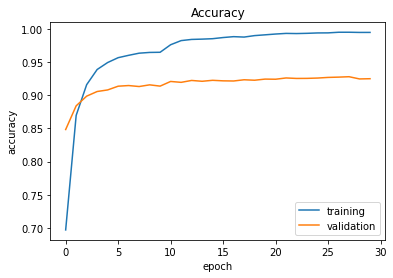

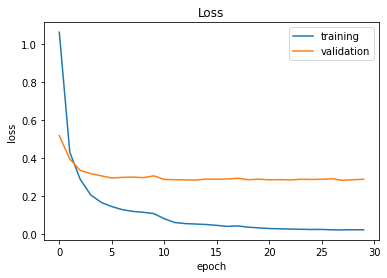

In [ ]:
lstm_train.display_results()

# GRU

### Definition

In [ ]:
class BiGRU(VanillaRNN):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout=0.0, device=torch.device('cpu')):
        super(BiGRU,self).__init__(embedding_dim,
                                   hidden_dim,
                                   output_dim,
                                   bidirectional=True,
                                   dropout=dropout,
                                   device=device)

        self.gru = torch.nn.GRU(input_size=embedding_dim,
                                hidden_size=hidden_dim,
                                bidirectional=True)

        self.end_init()


    def get_features(self, embeds):
        return self.gru(embeds, self.hidden)

In [ ]:
hidden_dim = 100

model_gru = BiGRU(embedding_dim = embedding_dim,
                  hidden_dim = hidden_dim,
                  output_dim = len(vocabulary_tags),
                  dropout = 0.2,
                  device = device)

### Training

In [ ]:
#criterion is defined in the last code block of the section "Training function"
optimizer = torch.optim.Adam(model_gru.parameters(), amsgrad=True, lr=0.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)

gru_train = Train(model = model_gru,
                  num_epochs = 30,
                  criterion = criterion,
                  optimizer = optimizer,
                  lr_scheduler = lr_scheduler,
                  lr_scheduler_metric = True,
                  ignore_enc = tag_to_encoding[IGNORE_ENC])

gru_train(training_iterator, validation_iterator)

Parameters Initialization ...
Done

Best validation accuracy initialization ...
Done

Beginning training procedure

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 1.003 | Train Acc: 70.98%
	 Val. Loss: 0.543 |  Val. Acc: 83.57%
	lr: 0.01 --> 0.01
Epoch: 02 | Epoch Time: 0m 3s
	Train Loss: 0.461 | Train Acc: 85.90%
	 Val. Loss: 0.419 |  Val. Acc: 87.23%
	lr: 0.01 --> 0.01
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.316 | Train Acc: 90.35%
	 Val. Loss: 0.374 |  Val. Acc: 88.53%
	lr: 0.01 --> 0.01
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.242 | Train Acc: 92.53%
	 Val. Loss: 0.363 |  Val. Acc: 89.53%
	lr: 0.01 --> 0.01
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.214 | Train Acc: 93.45%
	 Val. Loss: 0.366 |  Val. Acc: 89.67%
	lr: 0.01 --> 0.01
Epoch: 06 | Epoch Time: 0m 3s
	Train Loss: 0.208 | Train Acc: 93.56%
	 Val. Loss: 0.361 |  Val. Acc: 89.68%
	lr: 0.01 --> 0.01
Epoch: 07 | Epoch Time: 0m 3s
	Train Loss: 0.195 | Train Acc: 93.88%
	 Val. Loss: 0.375 |  Val. Acc: 89.86%
	lr: 0.01 --> 

### Display results


Best validation accuracy found at epoch 29: 91.7513%
F1-score: 0.7776606010543012




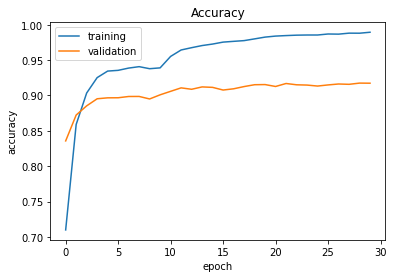

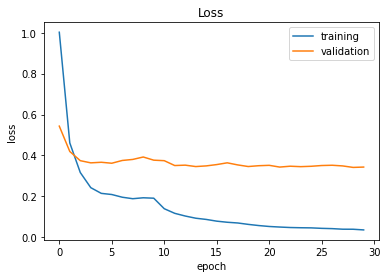

In [ ]:
gru_train.display_results()

# Double LSTM layer

### Definition

In [ ]:
class DoubleBiLSTM(VanillaRNN):
    def __init__(self, embedding_dim, hidden_dim, output_dim, dropout=0.0, dropout_fe=0.0, device=torch.device('cpu')):
        super(DoubleBiLSTM,self).__init__(embedding_dim,
                                          hidden_dim,
                                          output_dim,
                                          bidirectional=True,
                                          num_layers=2,
                                          num_hidden=2,
                                          dropout=dropout,
                                          device=device)

        self.lstm = torch.nn.LSTM(input_size=embedding_dim,
                                  hidden_size=hidden_dim,
                                  num_layers=2,
                                  bidirectional=True,
                                  dropout=dropout_fe)

        self.end_init()


    def get_features(self, embeds):
        return self.lstm(embeds, self.hidden)

In [ ]:
hidden_dim = 100

model_dlstm = DoubleBiLSTM(embedding_dim = embedding_dim,
                           hidden_dim = hidden_dim,
                           output_dim = len(vocabulary_tags),
                           dropout = 0.2,
                           dropout_fe = 0.3,
                           device = device)

### Training

In [ ]:
#criterion is defined in the last code block of the section "Training function"
optimizer = torch.optim.Adam(model_dlstm.parameters(), amsgrad=True, lr=0.01, weight_decay=1e-5) ##################TRY WITH WEIGHT DECAY AT 1e-5
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3, threshold=1e-3)

dlstm_train = Train(model = model_dlstm,
                    num_epochs = 30,
                    criterion = criterion,
                    optimizer = optimizer,
                    lr_scheduler = lr_scheduler,
                    lr_scheduler_metric = True,
                    ignore_enc = tag_to_encoding[IGNORE_ENC])

dlstm_train(training_iterator, validation_iterator)

Parameters Initialization ...
Done

Best validation accuracy initialization ...
Done

Beginning training procedure

Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 1.352 | Train Acc: 61.08%
	 Val. Loss: 0.551 |  Val. Acc: 84.16%
	lr: 0.01 --> 0.01
Epoch: 02 | Epoch Time: 0m 7s
	Train Loss: 0.483 | Train Acc: 85.71%
	 Val. Loss: 0.404 |  Val. Acc: 87.99%
	lr: 0.01 --> 0.01
Epoch: 03 | Epoch Time: 0m 7s
	Train Loss: 0.307 | Train Acc: 90.87%
	 Val. Loss: 0.363 |  Val. Acc: 89.54%
	lr: 0.01 --> 0.01
Epoch: 04 | Epoch Time: 0m 7s
	Train Loss: 0.234 | Train Acc: 92.89%
	 Val. Loss: 0.326 |  Val. Acc: 90.21%
	lr: 0.01 --> 0.01
Epoch: 05 | Epoch Time: 0m 7s
	Train Loss: 0.185 | Train Acc: 94.42%
	 Val. Loss: 0.325 |  Val. Acc: 90.73%
	lr: 0.01 --> 0.01
Epoch: 06 | Epoch Time: 0m 7s
	Train Loss: 0.157 | Train Acc: 95.24%
	 Val. Loss: 0.308 |  Val. Acc: 91.26%
	lr: 0.01 --> 0.01
Epoch: 07 | Epoch Time: 0m 7s
	Train Loss: 0.150 | Train Acc: 95.40%
	 Val. Loss: 0.329 |  Val. Acc: 91.15%
	lr: 0.01 --> 

### Display results


Best validation accuracy found at epoch 26: 93.1226%
F1-score: 0.7980418276330478




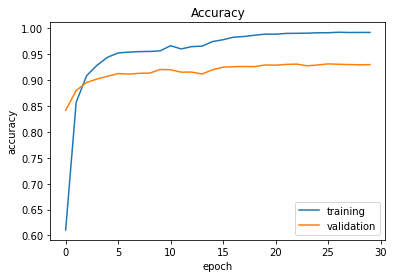

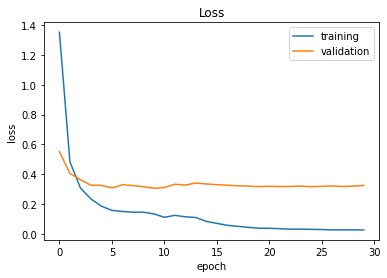

In [ ]:
dlstm_train.display_results()

# LSTM + CRF

### Definition

For this part of the assignment, since PyTorch doesn't define its own CRF layer,  it will be used an unofficial implementation called `pytorch-crf`

In [ ]:
!pip install pytorch-crf

In [ ]:
import torchcrf

Definition of the RNN

In [ ]:
class LSTM_CRF(VanillaRNN):
    def __init__(self, embedding_dim, hidden_dim, output_dim, ign_enc, dropout=0.0, device=torch.device('cpu')):
        super(LSTM_CRF,self).__init__(embedding_dim,
                                      hidden_dim,
                                      output_dim,
                                      bidirectional=True,
                                      num_hidden=2,
                                      dropout=dropout,
                                      device=device)

        self.ign_enc = ign_enc

        self.lstm = torch.nn.LSTM(input_size=embedding_dim,
                                  hidden_size=hidden_dim,
                                  bidirectional=True)

        self.crf = torchcrf.CRF(output_dim)

        self.end_init()

        
    def get_features(self, embeds):
        return self.lstm(embeds, self.hidden)

    def forward(self, sentence):
        predictions = super(LSTM_CRF,self).forward(sentence)
        return torch.tensor(self.crf.decode(predictions), dtype=torch.long, device=self.device).view(-1,1), predictions

    def neg_log_likelihood(self, predictions, tags):
        mask = (tags != self.ign_enc).view(-1,1)
        return -self.crf(predictions, tags.view(-1,1), mask=mask, reduction='mean')

In [ ]:
hidden_dim = 100

model_lstm_crf = LSTM_CRF(embedding_dim = embedding_dim,
                          hidden_dim = hidden_dim,
                          output_dim = len(vocabulary_tags),
                          ign_enc = tag_to_encoding[IGNORE_ENC],
                          dropout=0.2,
                          device = device)

### Training

In [ ]:
class TrainCRF(Train):
    def __init__(self, model, num_epochs, optimizer, lr_scheduler=None, lr_scheduler_metric=False,
                 ignore_enc=None, init_model=True, state_path='Assignment3-model.pt'):
        super(TrainCRF,self).__init__(model = model,
                                      num_epochs = num_epochs,
                                      criterion = None,
                                      optimizer = optimizer,
                                      lr_scheduler = lr_scheduler,
                                      lr_scheduler_metric = lr_scheduler_metric,
                                      ignore_enc = ignore_enc,
                                      init_model = init_model,
                                      state_path = state_path)
        

    def remove_initial_punctuation(self, text, tags):
        """
        Removes the punctuation at the beginning of the tags and text.
        This is done because having punctuation at the beginning causes
        problems using the mask in the neg_log_likelihood function.
        """
        start = 0
        for idx, t in enumerate(tags):
            if t!=self.ignore_enc:
                start = idx
                break
        
        return text[start:], tags[start:]

        
    def train(self, iterator, is_train=True):
        epoch_loss = 0
        epoch_acc = 0
        
        if is_train:
            self.model.train()
        else:
            self.model.eval()

        with torch.set_grad_enabled(is_train):
            for batch in notebook.tqdm(iterator, position=0, leave=True):
                text = batch['tokens']
                tags = batch['tags']

                text, tags = self.remove_initial_punctuation(text, tags)
                
                if is_train:
                    self.optimizer.zero_grad()

                best_tags, predictions = self.model(text)
                
                loss = self.model.neg_log_likelihood(predictions, tags)
                
                acc = self.accuracy_score(best_tags, tags.view(-1))
                
                if is_train:
                    loss.backward()
                    self.optimizer.step()
                
                epoch_loss += loss.item()
                epoch_acc += acc.item()
            
        return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
optimizer = torch.optim.Adam(model_lstm_crf.parameters(), amsgrad=True, lr=0.01, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

lstm_crf_train = TrainCRF(model = model_lstm_crf,
                          num_epochs = 30,
                          optimizer = optimizer,
                          lr_scheduler = lr_scheduler,
                          ignore_enc = tag_to_encoding[IGNORE_ENC])

lstm_crf_train(training_iterator, validation_iterator)

Parameters Initialization ...
Done

Best validation accuracy initialization ...



Done

Beginning training procedure




Epoch: 01 | Epoch Time: 1m 2s
	Train Loss: 313.240 | Train Acc: 72.17%
	 Val. Loss: 134.121 |  Val. Acc: 86.77%
	lr: 0.01 --> 0.01



Epoch: 02 | Epoch Time: 1m 2s
	Train Loss: 74.965 | Train Acc: 89.37%
	 Val. Loss: 51.679 |  Val. Acc: 89.88%
	lr: 0.01 --> 0.01



Epoch: 03 | Epoch Time: 1m 2s
	Train Loss: -9.428 | Train Acc: 92.29%
	 Val. Loss: 9.536 |  Val. Acc: 90.30%
	lr: 0.01 --> 0.01



Epoch: 04 | Epoch Time: 1m 2s
	Train Loss: -76.010 | Train Acc: 94.10%
	 Val. Loss: -43.535 |  Val. Acc: 91.31%
	lr: 0.01 --> 0.01



Epoch: 05 | Epoch Time: 1m 2s
	Train Loss: -129.978 | Train Acc: 95.10%
	 Val. Loss: -83.603 |  Val. Acc: 91.55%
	lr: 0.01 --> 0.01



Epoch: 06 | Epoch Time: 1m 2s
	Train Loss: -180.212 | Train Acc: 95.85%
	 Val. Loss: -120.465 |  Val. Acc: 91.55%
	lr: 0.01 --> 0.01



Epoch: 07 | Epoch Time: 1m 1s
	Train Loss: -230.540 | Train Acc: 96.35%
	 Val. Loss: -152.497 |  Val. Acc: 91.85%
	lr: 0.01 --> 0.01



Epoch: 08 | Epoch Time: 1m 1s
	Train Loss: -276.131 | Train Acc: 96.67%
	 Val. Loss: -194.548 |  Val. Acc: 91.85%
	lr: 0.01 --> 0.01



Epoch: 09 | Epoch Time: 1m 3s
	Train Loss: -322.268 | Train Acc: 97.11%
	 Val. Loss: -227.753 |  Val. Acc: 92.40%
	lr: 0.01 --> 0.01



Epoch: 10 | Epoch Time: 1m 3s
	Train Loss: -365.660 | Train Acc: 97.47%
	 Val. Loss: -266.007 |  Val. Acc: 91.62%
	lr: 0.01 --> 0.005



Epoch: 11 | Epoch Time: 1m 4s
	Train Loss: -404.614 | Train Acc: 97.69%
	 Val. Loss: -287.758 |  Val. Acc: 92.15%
	lr: 0.005 --> 0.005



Epoch: 12 | Epoch Time: 1m 3s
	Train Loss: -432.364 | Train Acc: 98.52%
	 Val. Loss: -306.789 |  Val. Acc: 92.17%
	lr: 0.005 --> 0.005



Epoch: 13 | Epoch Time: 1m 3s
	Train Loss: -455.347 | Train Acc: 98.64%
	 Val. Loss: -325.494 |  Val. Acc: 92.02%
	lr: 0.005 --> 0.005



Epoch: 14 | Epoch Time: 1m 2s
	Train Loss: -477.435 | Train Acc: 98.70%
	 Val. Loss: -343.144 |  Val. Acc: 92.32%
	lr: 0.005 --> 0.005



Epoch: 15 | Epoch Time: 1m 2s
	Train Loss: -500.060 | Train Acc: 98.75%
	 Val. Loss: -358.010 |  Val. Acc: 92.27%
	lr: 0.005 --> 0.005



Epoch: 16 | Epoch Time: 1m 2s
	Train Loss: -522.523 | Train Acc: 98.61%
	 Val. Loss: -377.425 |  Val. Acc: 92.16%
	lr: 0.005 --> 0.005



Epoch: 17 | Epoch Time: 1m 1s
	Train Loss: -544.174 | Train Acc: 98.88%
	 Val. Loss: -394.430 |  Val. Acc: 91.99%
	lr: 0.005 --> 0.005



Epoch: 18 | Epoch Time: 1m 1s
	Train Loss: -566.747 | Train Acc: 98.91%
	 Val. Loss: -415.216 |  Val. Acc: 92.29%
	lr: 0.005 --> 0.005



Epoch: 19 | Epoch Time: 1m 1s
	Train Loss: -588.581 | Train Acc: 99.06%
	 Val. Loss: -431.870 |  Val. Acc: 92.37%
	lr: 0.005 --> 0.005



Epoch: 20 | Epoch Time: 1m 1s
	Train Loss: -610.714 | Train Acc: 98.84%
	 Val. Loss: -450.726 |  Val. Acc: 92.63%
	lr: 0.005 --> 0.0025



Epoch: 21 | Epoch Time: 1m 1s
	Train Loss: -628.116 | Train Acc: 99.27%
	 Val. Loss: -461.936 |  Val. Acc: 92.86%
	lr: 0.0025 --> 0.0025



Epoch: 22 | Epoch Time: 1m 1s
	Train Loss: -639.036 | Train Acc: 99.18%
	 Val. Loss: -471.462 |  Val. Acc: 92.51%
	lr: 0.0025 --> 0.0025



Epoch: 23 | Epoch Time: 1m 1s
	Train Loss: -650.807 | Train Acc: 99.25%
	 Val. Loss: -478.964 |  Val. Acc: 92.47%
	lr: 0.0025 --> 0.0025



Epoch: 24 | Epoch Time: 1m 1s
	Train Loss: -662.111 | Train Acc: 99.31%
	 Val. Loss: -487.409 |  Val. Acc: 92.41%
	lr: 0.0025 --> 0.0025



Epoch: 25 | Epoch Time: 1m 1s
	Train Loss: -672.434 | Train Acc: 99.42%
	 Val. Loss: -498.091 |  Val. Acc: 92.37%
	lr: 0.0025 --> 0.0025



Epoch: 26 | Epoch Time: 1m 1s
	Train Loss: -683.815 | Train Acc: 99.47%
	 Val. Loss: -508.240 |  Val. Acc: 92.45%
	lr: 0.0025 --> 0.0025



Epoch: 27 | Epoch Time: 1m 1s
	Train Loss: -694.860 | Train Acc: 99.38%
	 Val. Loss: -515.396 |  Val. Acc: 92.36%
	lr: 0.0025 --> 0.0025



Epoch: 28 | Epoch Time: 1m 1s
	Train Loss: -705.810 | Train Acc: 99.33%
	 Val. Loss: -526.056 |  Val. Acc: 92.66%
	lr: 0.0025 --> 0.0025



Epoch: 29 | Epoch Time: 1m 0s
	Train Loss: -716.509 | Train Acc: 99.37%
	 Val. Loss: -534.757 |  Val. Acc: 92.55%
	lr: 0.0025 --> 0.0025



Epoch: 30 | Epoch Time: 1m 0s
	Train Loss: -728.027 | Train Acc: 99.53%
	 Val. Loss: -544.147 |  Val. Acc: 92.70%
	lr: 0.0025 --> 0.00125


Loading the model with the best validation accuracy ...
Model loaded with results of epoch 21 and with validation accuracy of 92.85540461540222%


### Display results


Best validation accuracy found at epoch 21: 92.8554%
F1-score: 0.7938800134624515




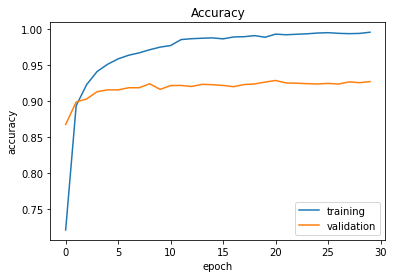

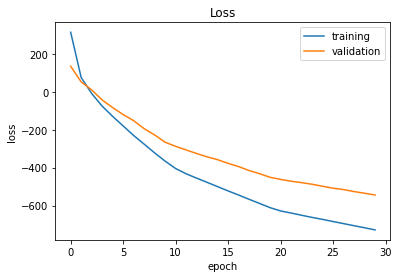

In [ ]:
lstm_crf_train.display_results()

# Test Evaluation
In the end, the test set will be evaluated using the best model.<br>
Many runs of the models' training revealed that, as far as F1-macro computed on the validation set is concerned, BiLSTM with two layers and LSTM+CRF holds similar results making it difficult to decide which model has to be selected.<br>
Still, since a decision has to be done, it's going to be selected BiLSTM with 2 layers (F1-macro-wise it gave slight better results on the last runs and the accuracy is overall better than LSTM+CRF).

In [ ]:
print('The F1-macro score on the test set is:')
print(compute_f1_score(model_dlstm, test_iterator, ign_enc=tag_to_encoding[IGNORE_ENC]))

The F1-macro score on the test set is:
0.8083349929695756


# Final considerations
Through many experimentations it has been observed that the best model between the proposed ones is the BiLSTM with two layers.<br>
This result is expected, at least with respect to the baseline since, being deeper, it should be able to extract features with greater significance.<br>
GRU has been defeated by the other models, which may not be completely unexpected <sup>[1][2]</sup>.<br>
As for what concern LSTM+CRF from the empirical analysis performed on the model it seems that the CRF layer is at times able to outperform in terms of F1-macro score the BiLSTM with two layers. The overall performance of this model though, may be limited by the particular results given by the loss function which made difficult the usage of more refined learning rate scheduler such as `ReduceLROnPlateau`.<br><br>

Some additional methods have been deployed during the course of this assignment in order to improve the outcome of all the previously described models.<br>
It has been used a dropout layer as regularization factor.<br>
As optimizer it has been used Adam with amsgrad<sup>[3]</sup> with a properly tuned learning rate and weight decay.<br>
Since after many trials it has been observed that a static learning rate is not able to bring good results in a manageable amount of epochs it has been introduced an adaptive learning rate through a learning rate scheduler. In particular for almost all the models it has been used `ReduceLROnPlateau` lr_scheduler since, when properly tuned, it showed greater adaptivity with respect to other learning rate scheduler. As already mentioned above using such scheduler it has not been possible in the case of the LSTM+CRF model for which it has instead been used `StepLR` which decrease the learning rate of a certain factor after a fixed number of steps.<br><br><br>

### **How to improve**
There are different approaches that can help to bring better results.<br>
For instance in can be tried to use more regularization techniques such as recurrent dropout<sup>[4]</sup> and zoneout<sup>[5]</sup>.<br>
Adding skip-layer connections should be of help and be still within the architectural requirements of the assignment.<br>
Another approach would be to use better strategies to handle the creation of out of vocabulary words embedding.<br>
It could be also explored the possibility of handling the dataset as to address the umbalancement of the tags (maybe using some downsampling / upsampling / examples reweighting<sup>[6]</sup> techniques).<br>


<br><br>
<sup>[1]</sup> "Comparative Study of CNN and RNN for Natural Language Processing" (Wenpeng Yin et al. 2017) https://arxiv.org/pdf/1702.01923.pdf<br>
<sup>[2]</sup> "Empirical Evaluation of Gated Recurrent Neural Networks on Sequence Modeling" (Junyoung Chun et al. 2014) https://arxiv.org/pdf/1412.3555v1.pdf<br>
<sup>[3]</sup> "On the Convergence of Adam and Beyond" (Sashank J. Redd et al. 2018) https://openreview.net/pdf?id=ryQu7f-RZ<br>
<sup>[4]</sup> "Recurrent Dropout without Memory Loss" (Stanislau Semeniuta et al. 2016) https://arxiv.org/pdf/1603.05118.pdf<br>
<sup>[5]</sup> "Zoneout: Regularizing RNNs by Randomly Preserving Hidden Activations" (David Krueger et al. 2017) https://arxiv.org/pdf/1606.01305.pdf<br>
<sup>[6]</sup> "Learning to Reweight Examples for Robust Deep Learning" (Mengye Ren et al. 2019) https://arxiv.org/pdf/1803.09050.pdf<br>